In [33]:
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle
import tensorflow as tf

In [34]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"
EQUALITY_CONSTRAINT_ONE = "EQUALITY_CONSTRAINT_ONE"
EQUALITY_CONSTRAINT_TWO = "EQUALITY_CONSTRAINT_TWO"

In [51]:
def process_ts_lsq_results(result_dir: str,
                           num_runs: int,
                           failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [52]:
def process_ts_gsbp_results(result_dir: str,
                            num_runs: int,
                            failure_val: float,
                            equality_tolerance: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        equality_constraint_one_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze()) <= equality_tolerance
        equality_constraint_two_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze()) <= equality_tolerance
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, equality_constraint_one_satisfied)
        satisfied_mask = np.logical_and(satisfied_mask, equality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.4, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [53]:
def process_original_albo_lsq_results(result_dir: str,
                                      num_runs: int,
                                      failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(np.minimum.accumulate(run_results))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [54]:
def process_original_albo_gsbp_results(result_dir: str,
                                       num_runs: int,
                                       failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            all_results.append(np.minimum.accumulate(run_results))
    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.4, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [55]:
def process_kkt_lsq_results(result_dir: str,
                            num_runs: int,
                            failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))

    # Not all runs last 50 iterations due to early stopping criteria
    for i in range(len(all_results)):
        run_results = all_results[i].tolist()
        if len(run_results) < 50:
            deficit = 50 - len(run_results)
            additional_array = deficit * [run_results[-1]]
            run_results += additional_array
            all_results[i] = run_results

    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [56]:
def process_kkt_gsbp_results(result_dir: str,
                            num_runs: int,
                            failure_val: float,
                            equality_tolerance: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        equality_constraint_one_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze()) <= equality_tolerance
        equality_constraint_two_satisfied = np.abs(run_data[EQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze()) <= equality_tolerance
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, equality_constraint_one_satisfied)
        satisfied_mask = np.logical_and(satisfied_mask, equality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))

    # Not all runs last 160 iterations due to early stopping criteria
    for i in range(len(all_results)):
        run_results = all_results[i].tolist()
        if len(run_results) < 160:
            deficit = 160 - len(run_results)
            additional_array = deficit * [run_results[-1]]
            run_results += additional_array
            all_results[i] = run_results

    all_results = np.array(all_results)
    all_results = np.where(all_results < -0.4, -0.5273951, all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

### LSQ

In [79]:
ts_al_adam_lsq_results, ts_al_adam_lsq_results_mean, ts_al_adam_lsq_results_median, ts_al_adam_lsq_results_std = process_ts_lsq_results("../results/final_ts_results/lsq/adam/data/", 100, 1.7)
ts_al_bfgs_lsq_results, ts_al_bfgs_lsq_results_mean, ts_al_bfgs_lsq_results_median, ts_al_bfgs_lsq_results_std = process_ts_lsq_results("../results/final_ts_results/lsq/l_bfgs_b/data/", 100, 1.7)
original_albo_lsq_results, original_albo_lsq_results_mean, original_albo_lsq_results_median, original_albo_lsq_results_std = process_original_albo_lsq_results("../results/final_original_results/lsq/slack_optim/data/", 100, 1.7)
original_albo_no_ey_lsq_results, original_albo_no_ey_lsq_results_mean, original_albo_no_ey_lsq_results_median, original_albo_no_ey_lsq_results_std = process_original_albo_lsq_results("../results/final_original_results/lsq/slack_optim_no_ey/data/", 100, 1.7)
ts_al_adam_rbf_lsq_results, ts_al_adam_rbf_lsq_results_mean, ts_al_adam_rbf_lsq_results_median, ts_al_adam_rbf_lsq_results_std = process_ts_lsq_results("../results/final_ts_results/lsq/adam_no_prev_rbf/data/", 100, 1.7)
random_lsq_results, random_lsq_results_mean, random_lsq_results_median, random_lsq_results_std = process_ts_lsq_results("../results/11-04-23/lsq_random/", 100, 1.7)
final_kkt_lsq_results, final_kkt_lsq_results_mean, final_kkt_lsq_results_median, final_kkt_lsq_results_std = process_kkt_lsq_results("../results/extra_kkt_results/lsq_refined/data/", 100, 1.7)
final_kkt_feasible_only_lsq_results, final_kkt_feasible_only_lsq_results_mean, final_kkt_feasible_only_lsq_results_median, final_kkt_feasible_only_lsq_results_std = process_kkt_lsq_results("../results/extra_kkt_results/lsq_feasible_only/data/", 100, 1.7)

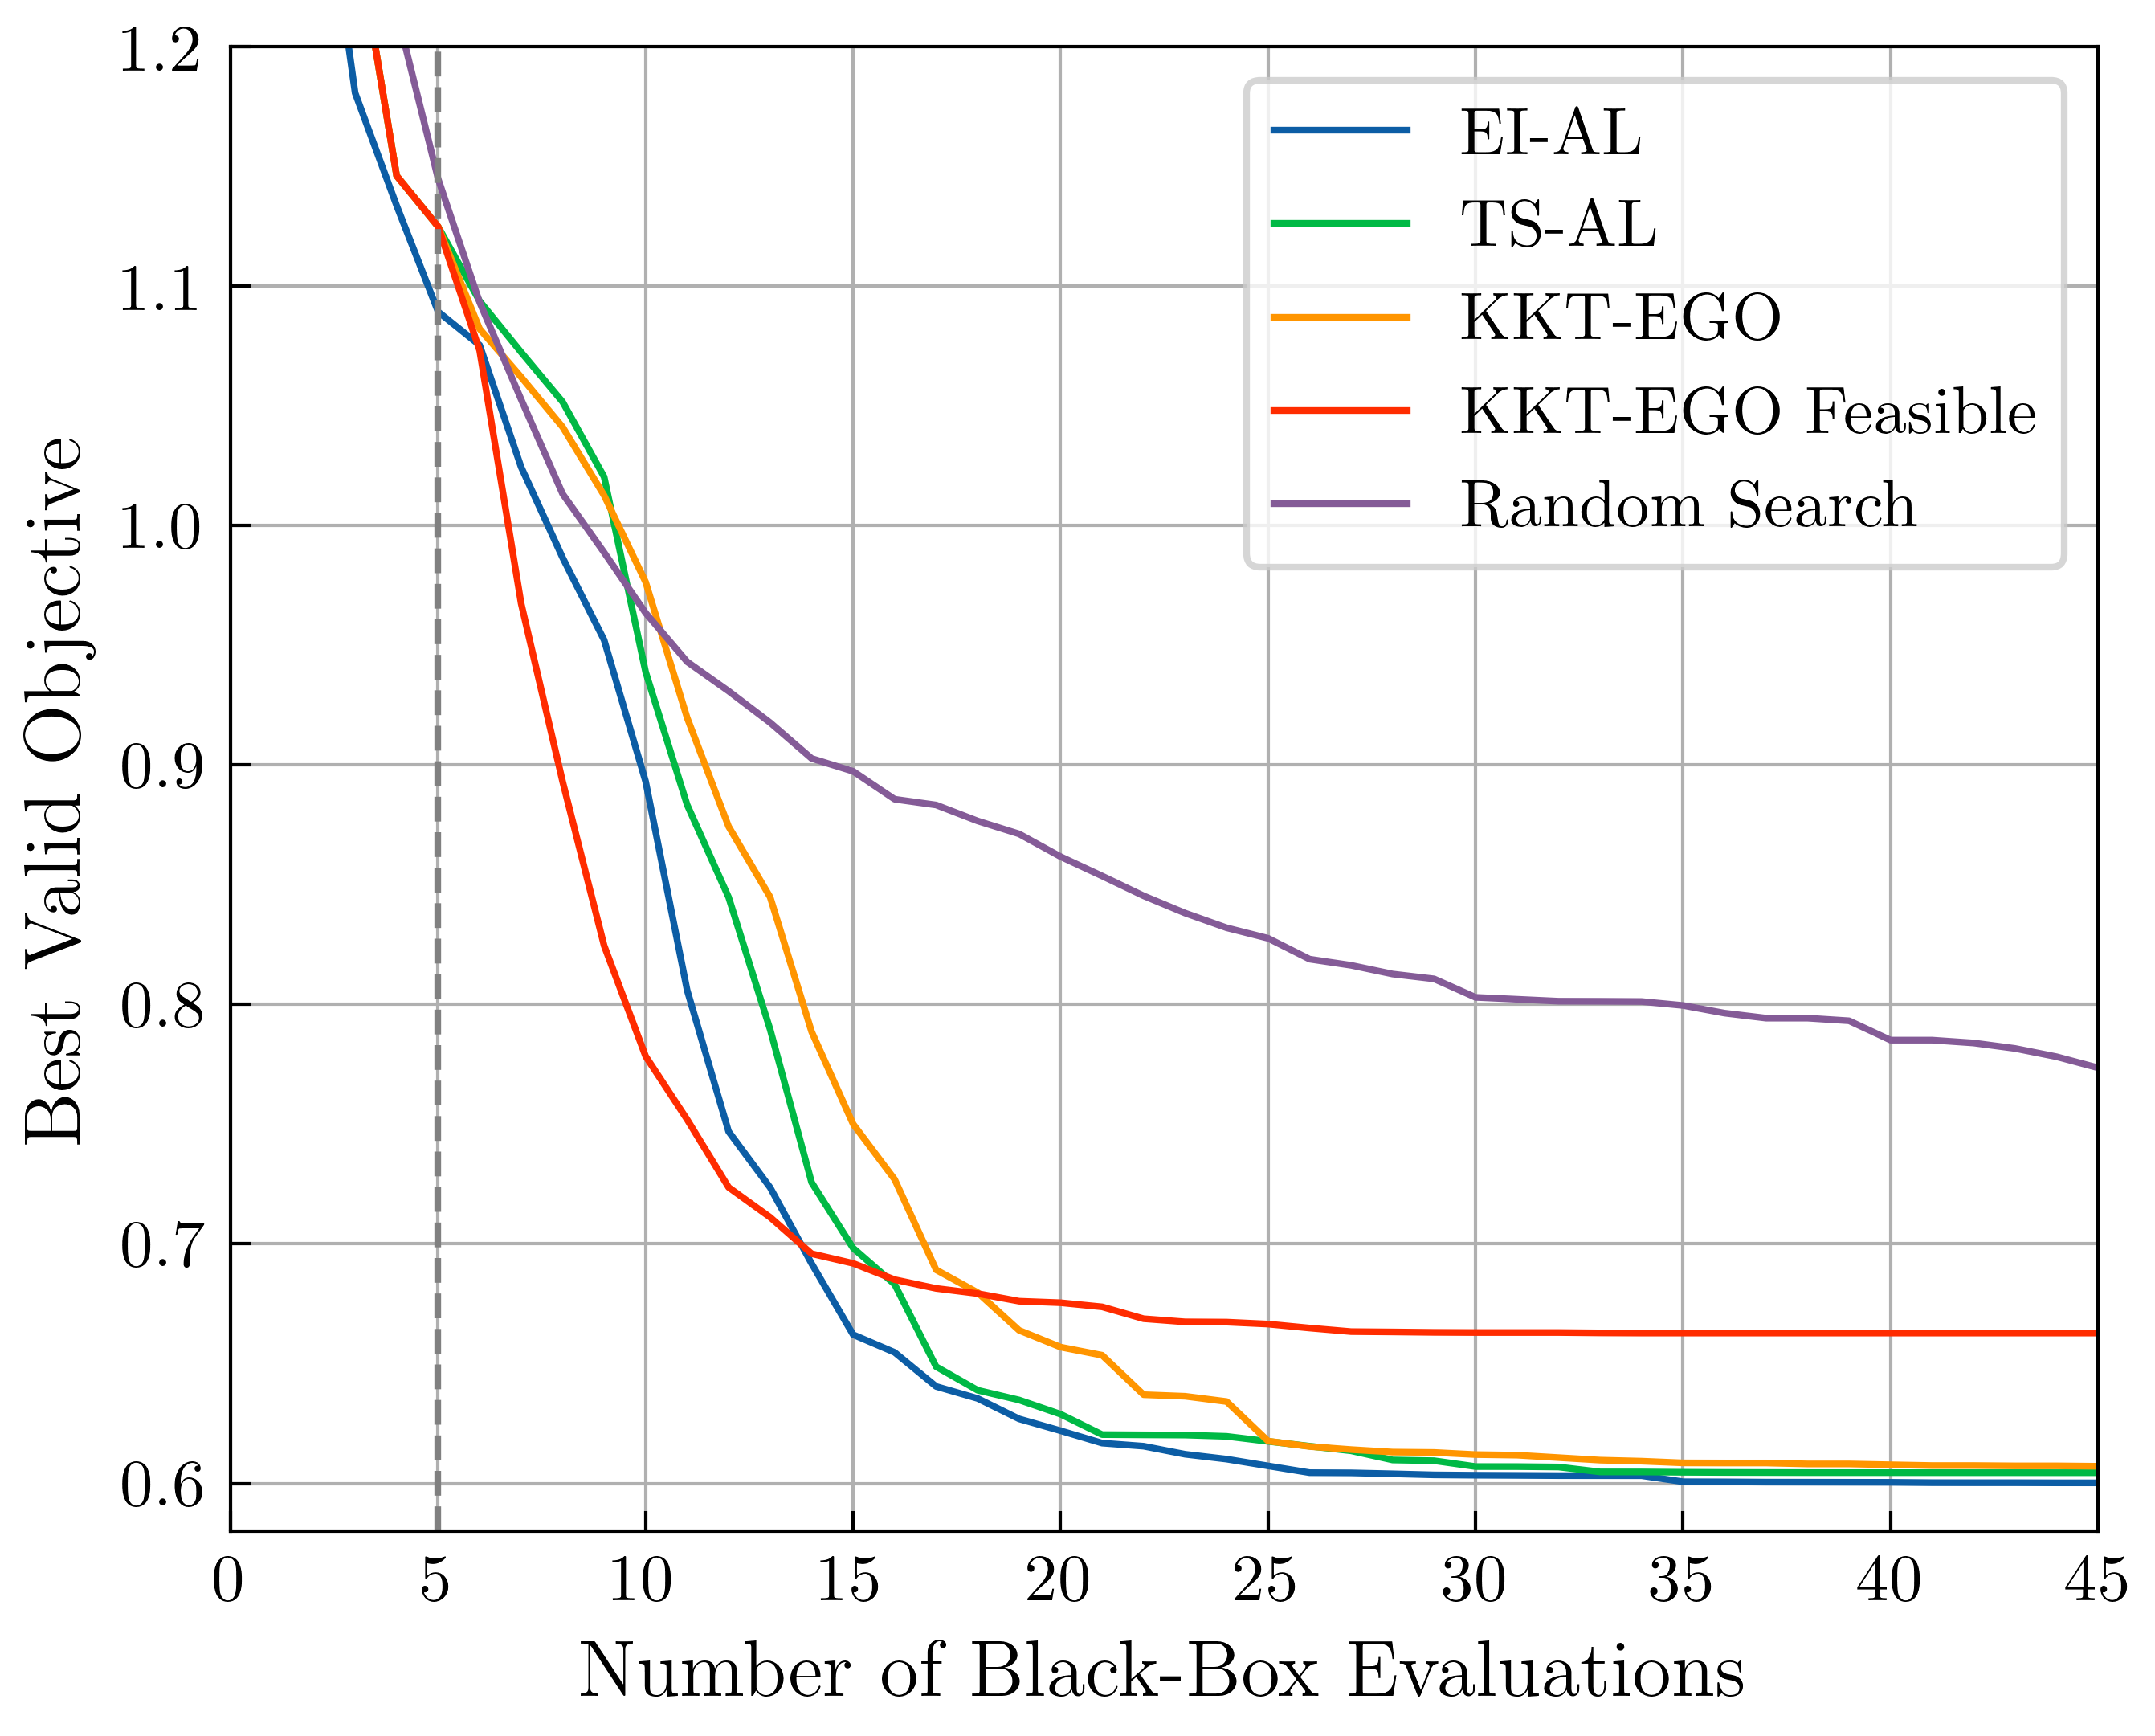

In [80]:
plt.style.use('plot_style.txt')
# Was (6, 4.5)
plt.figure(figsize=(5, 4))
iters = [i for i in range(1, 46)]
# plt.plot(iters, original_albo_lsq_results_mean, label="EI-AL")
plt.plot(iters, original_albo_no_ey_lsq_results_mean, label="EI-AL")
plt.plot(iters, ts_al_adam_rbf_lsq_results_mean, label="TS-AL")
# plt.plot(iters, kkt_lsq_results_mean[:45], label="KKT-EGO")
plt.plot(iters, final_kkt_lsq_results_mean[:45], label="KKT-EGO")
# plt.plot(iters, kkt_feasible_only_lsq_results_mean[:45], label="KKT-EGO Feasible")
plt.plot(iters, final_kkt_feasible_only_lsq_results_mean[:45], label="KKT-EGO Feasible")
plt.plot(iters, random_lsq_results_mean[:45], label="Random Search")
# plt.plot(iters, ts_al_adam_lsq_results_mean, label="TS-AL + Adam")
# plt.plot(iters, ts_al_bfgs_lsq_results_mean, label="TS-AL + L-BFGS-B")
plt.axvline(x=5, color='grey', linestyle='--')
# plt.fill_between(iters, kkt_lsq_results_mean[:45]+kkt_lsq_results_std[:45], kkt_lsq_results_mean[:45]-kkt_lsq_results_std[:45], alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, kkt_feasible_only_lsq_results_mean[:45]+kkt_feasible_only_lsq_results_std[:45], kkt_feasible_only_lsq_results_mean[:45]-kkt_feasible_only_lsq_results_std[:45], alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, original_albo_lsq_results_mean[:45]+original_albo_lsq_results_std[:45], original_albo_lsq_results_mean[:45]-original_albo_lsq_results_std[:45], alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, random_lsq_results_mean[:45]+random_lsq_results_std[:45], random_lsq_results_mean[:45]-random_lsq_results_std[:45], alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, ts_al_adam_rbf_lsq_results_mean[:45]+ts_al_adam_rbf_lsq_results_std[:45], ts_al_adam_rbf_lsq_results_mean[:45]-ts_al_adam_rbf_lsq_results_std[:45], alpha=0.1, linestyle='-', linewidth=2)
plt.xlabel('Number of Black-Box Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.xlim(0, 45)
plt.ylim(0.58, 1.2)
# plt.savefig("figs/lsq_results.png")
plt.show()

In [72]:
key_iterations = [20, 30, 40]

In [73]:
# TS-AL
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(ts_al_adam_rbf_lsq_results, 5, axis=0)[iter-1]}, Median: {ts_al_adam_rbf_lsq_results_median[iter-1]}, 95%: {np.percentile(ts_al_adam_rbf_lsq_results, 95, axis=0)[iter-1]}")

Iter: 20
5%: 0.5998593489177979, Median: 0.6003279575691578, 95%: 0.7531955350310607
Iter: 30
5%: 0.5998152864957771, Median: 0.5999300339479345, 95%: 0.6295436339778235
Iter: 40
5%: 0.5998036802440723, Median: 0.599891539802607, 95%: 0.6007855210288258


In [74]:
# EI-AL No EY
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_no_ey_lsq_results, 5, axis=0)[iter-1]}, Median: {original_albo_no_ey_lsq_results_median[iter-1]}, 95%: {np.percentile(original_albo_no_ey_lsq_results, 95, axis=0)[iter-1]}")

Iter: 20
5%: 0.599947980783681, Median: 0.601722319287519, 95%: 0.7579191329524442
Iter: 30
5%: 0.5998412637650322, Median: 0.6003065595551189, 95%: 0.6029095747434653
Iter: 40
5%: 0.5998262412843854, Median: 0.6001548033033606, 95%: 0.601000747460936


In [75]:
# EI-AL
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_lsq_results, 5, axis=0)[iter-1]}, Median: {original_albo_lsq_results_median[iter-1]}, 95%: {np.percentile(original_albo_lsq_results, 95, axis=0)[iter-1]}")

Iter: 20
5%: 0.5998567476691583, Median: 0.6011887516588801, 95%: 0.7579191329524442
Iter: 30
5%: 0.5997995990741063, Median: 0.5999343089466855, 95%: 0.6027762074763956
Iter: 40
5%: 0.5997995990741063, Median: 0.5998988730620645, 95%: 0.6008144295421931


In [76]:
# Random
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.round(np.percentile(random_lsq_results, 5, axis=0)[iter-1], 4)}, Median: {np.round(random_lsq_results_median[iter-1], 4)}, 95%: {np.round(np.percentile(random_lsq_results, 95, axis=0), 4)[iter-1]}")

Iter: 20
5%: 0.6531, Median: 0.8732, 95%: 1.0747
Iter: 30
5%: 0.6322, Median: 0.7829, 95%: 1.0193
Iter: 40
5%: 0.6282, Median: 0.77, 95%: 0.9679


In [81]:
# Final KKT-EGO
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(final_kkt_lsq_results, 5, axis=0)[iter-1]}, Median: {final_kkt_lsq_results_median[iter-1]}, 95%: {np.percentile(final_kkt_lsq_results, 95, axis=0)[iter-1]}")

Iter: 20
5%: 0.6008394157929481, Median: 0.6176576706277708, 95%: 0.8644435766631118
Iter: 30
5%: 0.60021883143973, Median: 0.6040773837338387, 95%: 0.6350490799875003
Iter: 40
5%: 0.6002016649795079, Median: 0.6022022453819198, 95%: 0.6234337967885384


In [78]:
# Final KKT-EGO Feasible Only
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(final_kkt_feasible_only_lsq_results, 5, axis=0)[iter-1]}, Median: {final_kkt_feasible_only_lsq_results_median[iter-1]}, 95%: {np.percentile(final_kkt_feasible_only_lsq_results, 95, axis=0)[iter-1]}")

Iter: 20
5%: 0.6002537957182225, Median: 0.6061744934484969, 95%: 0.817169586622906
Iter: 30
5%: 0.6001037499846544, Median: 0.6027817628770801, 95%: 0.778498653383953
Iter: 40
5%: 0.6001037499846544, Median: 0.60251751407925, 95%: 0.778498653383953


### GSBP

In [57]:
ts_al_adam_aggressive_gsbp_results, ts_al_adam_aggressive_gsbp_results_mean, ts_al_adam_aggressive_gsbp_results_median, ts_al_adam_aggressive_gsbp_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_aggressive/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_conservative_gsbp_results, ts_al_adam_conservative_gsbp_results_mean, ts_al_adam_conservative_gsbp_results_median, ts_al_adam_conservative_gsbp_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_conservative/data/", 50, 2.1, equality_tolerance=0.01)
original_albo_aggressive_no_ey_gsbp_results, original_albo_aggressive_no_ey_gsbp_results_mean, original_albo_aggressive_no_ey_gsbp_results_median, original_albo_aggressive_no_ey_gsbp_results_std = process_original_albo_gsbp_results("../results/final_original_results/gsbp/slack_optim_aggressive_no_ey/data/", 50, 2.1)
original_albo_aggressive_gsbp_results, original_albo_aggressive_gsbp_results_mean, original_albo_aggressive_gsbp_results_median, original_albo_aggressive_gsbp_results_std = process_original_albo_gsbp_results("../results/final_original_results/gsbp/slack_optim_aggressive/data/", 50, 2.1)
original_albo_conservative_no_ey_gsbp_results, original_albo_conservative_no_ey_gsbp_results_mean, original_albo_conservative_no_ey_gsbp_results_median, original_albo_conservative_no_ey_gsbp_results_std = process_original_albo_gsbp_results("../results/final_original_results/gsbp/slack_optim_conservative_no_ey/data/", 50, 2.1)
original_albo_conservative_gsbp_results, original_albo_conservative_gsbp_results_mean, original_albo_conservative_gsbp_results_median, original_albo_conservative_gsbp_results_std = process_original_albo_gsbp_results("../results/final_original_results/gsbp/slack_optim_conservative/data/", 50, 2.1)
random_gsbp_results, random_gsbp_results_mean, random_gsbp_results_median, random_gsbp_results_std = process_ts_gsbp_results("../results/11-04-23/gsbp_random/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_no_prev_aggressive_results, ts_al_adam_no_prev_aggressive_results_mean, ts_al_adam_no_prev_aggressive_results_median, ts_al_adam_no_prev_aggressive_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_no_prev_aggressive/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_no_prev_conservative_results, ts_al_adam_no_prev_conservative_results_mean, ts_al_adam_no_prev_conservative_results_median, ts_al_adam_no_prev_conservative_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_no_prev_conservative/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_no_prev_rbf_aggressive_results, ts_al_adam_no_prev_rbf_aggressive_results_mean, ts_al_adam_no_prev_rbf_aggressive_results_median, ts_al_adam_no_prev_rbf_aggressive_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_no_prev_rbf_aggressive/data/", 50, 2.1, equality_tolerance=0.01)
ts_al_adam_no_prev_rbf_conservative_results, ts_al_adam_no_prev_rbf_conservative_results_mean, ts_al_adam_no_prev_rbf_conservative_results_median, ts_al_adam_no_prev_rbf_conservative_results_std = process_ts_gsbp_results("../results/final_ts_results/gsbp/adam_no_prev_rbf_conservative/data/", 50, 2.1, equality_tolerance=0.01)
# kkt_gsbp_results, kkt_gsbp_results_mean, kkt_gsbp_results_median, kkt_gsbp_results_std = process_kkt_gsbp_results("../results/09-04-23/kkt_gsbp_ts/data/", 15, 2.1, equality_tolerance=0.01)
# kkt_feasible_only_gsbp_results, kkt_feasible_only_gsbp_results_mean, kkt_feasible_only_gsbp_results_median, kkt_feasible_only_gsbp_results_std = process_kkt_gsbp_results("../results/09-04-23/kkt_gsbp_feasible_only_ts/data/", 15, 2.1, equality_tolerance=0.01)
final_kkt_feasible_only_gsbp_results, final_kkt_feasible_only_gsbp_results_mean, final_kkt_feasible_only_gsbp_results_median, final_kkt_feasible_only_gsbp_results_std = process_kkt_gsbp_results("../results/extra_kkt_results/gsbp_feasible_only/data/", 20, 2.1, equality_tolerance=0.01)
final_kkt_gsbp_results, final_kkt_gsbp_results_mean, final_kkt_gsbp_results_median, final_kkt_gsbp_results_std = process_kkt_gsbp_results("../results/extra_kkt_results/gsbp_refined/data/", 20, 2.1, equality_tolerance=0.01)

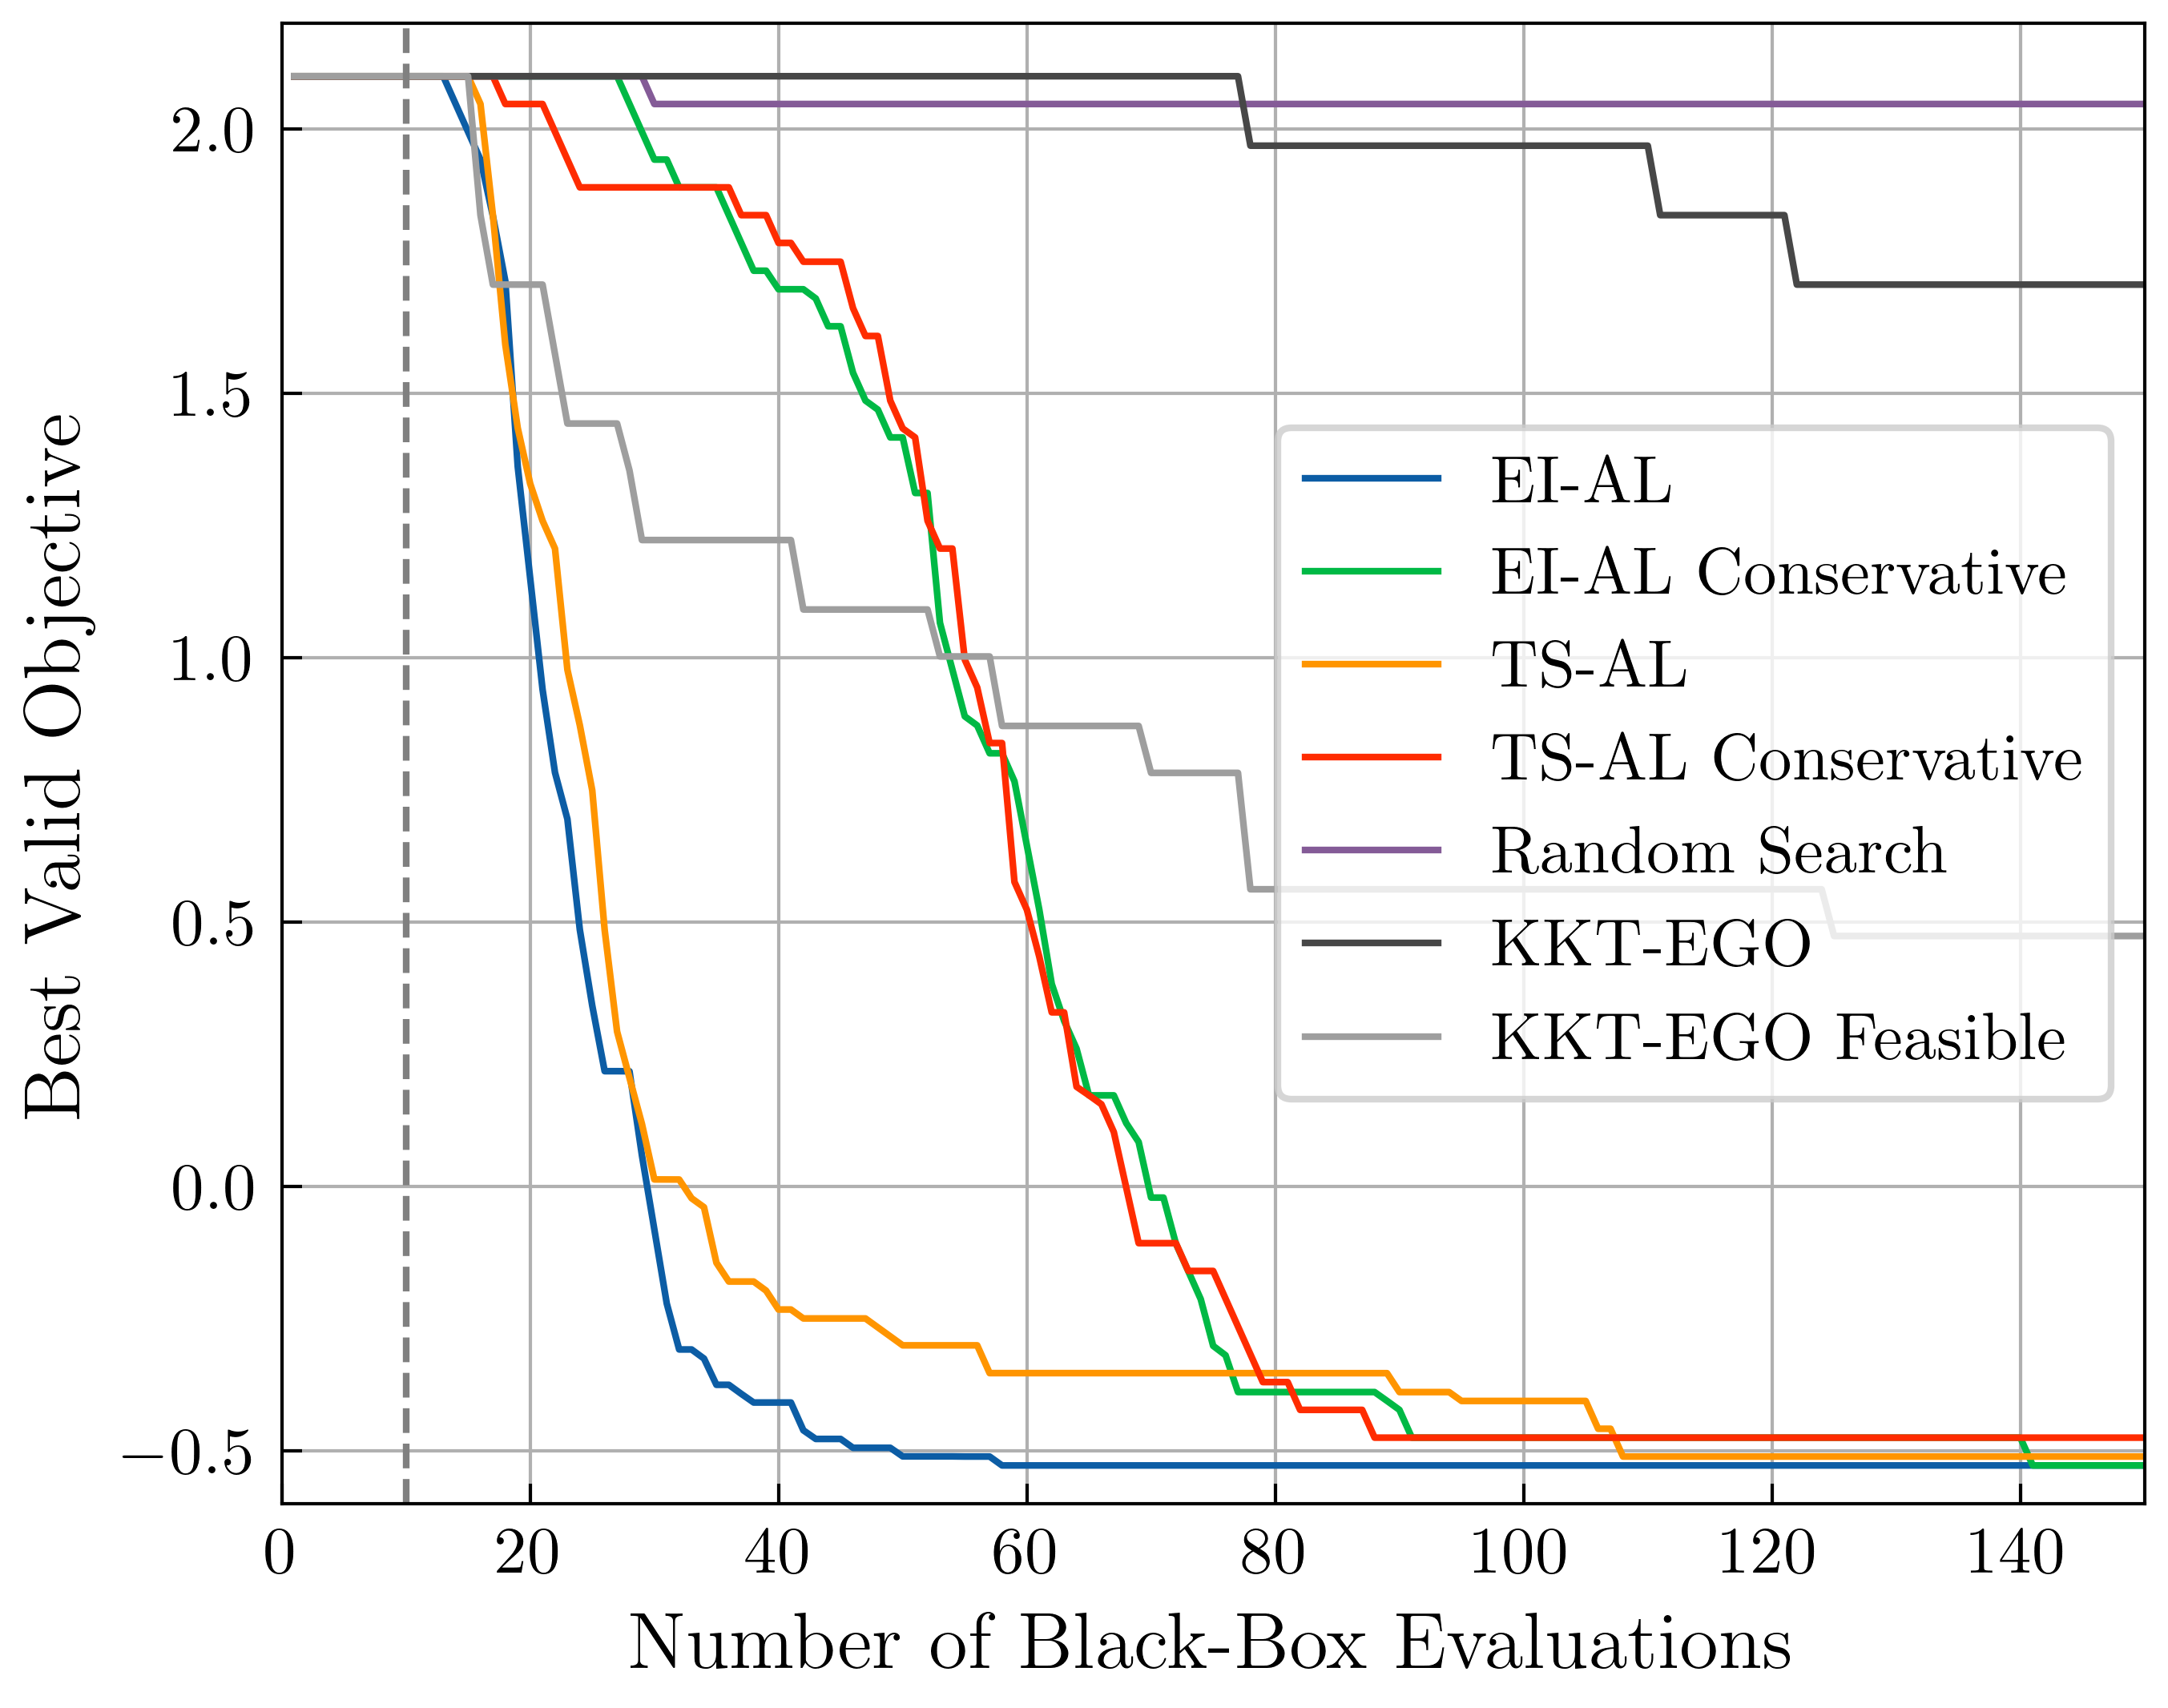

In [66]:
plt.style.use('plot_style.txt')
plt.figure(figsize=(5, 4))
iters = [i for i in range(1, 151)]
# plt.plot(iters, original_albo_aggressive_gsbp_results_mean, label="EI-AL")
plt.plot(iters, original_albo_aggressive_no_ey_gsbp_results_mean, label="EI-AL")
# plt.plot(iters, original_albo_conservative_gsbp_results_mean, label="EI-AL Conservative")
plt.plot(iters, original_albo_conservative_no_ey_gsbp_results_mean, label="EI-AL Conservative")
plt.plot(iters, ts_al_adam_no_prev_rbf_aggressive_results_mean, label="TS-AL")
plt.plot(iters, ts_al_adam_no_prev_rbf_conservative_results_mean, label="TS-AL Conservative")
plt.plot(iters, random_gsbp_results_mean, label="Random Search")
# plt.plot(iters, kkt_gsbp_results_mean[:150], label="KKT-EGO")
plt.plot(iters, final_kkt_gsbp_results_mean[:150], label="KKT-EGO")
# plt.plot(iters, kkt_feasible_only_gsbp_results_mean[:150], label="KKT-EGO Feasible")
plt.plot(iters, final_kkt_feasible_only_gsbp_results_mean[:150], label="KKT-EGO Feasible")
# plt.fill_between(iters, original_albo_aggressive_gsbp_results_mean+original_albo_aggressive_gsbp_results_std, original_albo_aggressive_gsbp_results_mean-original_albo_aggressive_gsbp_results_std, alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, original_albo_conservative_gsbp_results_mean+original_albo_conservative_gsbp_results_std, original_albo_conservative_gsbp_results_mean-original_albo_conservative_gsbp_results_std, alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, ts_al_adam_no_prev_rbf_conservative_results_mean+ts_al_adam_no_prev_rbf_conservative_results_std, ts_al_adam_no_prev_rbf_conservative_results_mean-ts_al_adam_no_prev_rbf_conservative_results_std, alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, ts_al_adam_no_prev_rbf_aggressive_results_mean+ts_al_adam_no_prev_rbf_aggressive_results_std, ts_al_adam_no_prev_rbf_aggressive_results_mean-ts_al_adam_no_prev_rbf_aggressive_results_std, alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, random_gsbp_results_mean+random_gsbp_results_std, random_gsbp_results_mean-random_gsbp_results_std, alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, kkt_gsbp_results_mean[:150]+kkt_gsbp_results_std[:150], kkt_gsbp_results_mean[:150]-kkt_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
# plt.fill_between(iters, kkt_feasible_only_gsbp_results_mean[:150]+kkt_feasible_only_gsbp_results_std[:150], kkt_feasible_only_gsbp_results_mean[:150]-kkt_feasible_only_gsbp_results_std[:150], alpha=0.1, linestyle='-', linewidth=2)
plt.axvline(x=10, color='grey', linestyle='--')
plt.xlabel('Number of Black-Box Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
plt.xlim(0, 150)
plt.ylim(-0.6, 2.2)
plt.savefig("figs/gsbp_results.png")
plt.show()

In [62]:
def fraction_of_runs_found_feasible_point(all_runs: np.array,
                                          num_runs: int,
                                          failure_val: float):
    assert(all_runs.shape[0] == num_runs)
    found_feasible_point = np.where(all_runs == failure_val, 0, 1)
    feasible_fraction = np.sum(found_feasible_point, axis=0)/num_runs
    return feasible_fraction

In [64]:
feasible_fraction_adam_aggressive = fraction_of_runs_found_feasible_point(ts_al_adam_aggressive_gsbp_results, 50, 2.1)
feasible_fraction_adam_conservative = fraction_of_runs_found_feasible_point(ts_al_adam_conservative_gsbp_results, 50, 2.1)
feasible_fraction_random = fraction_of_runs_found_feasible_point(random_gsbp_results, 50, 2.1)
feasible_fraction_original_albo_no_ey_aggressive = fraction_of_runs_found_feasible_point(original_albo_aggressive_no_ey_gsbp_results, 50, 2.1)
feasible_fraction_original_albo_no_ey_conservative = fraction_of_runs_found_feasible_point(original_albo_conservative_no_ey_gsbp_results, 50, 2.1)
feasible_fraction_adam_no_prev_aggressive = fraction_of_runs_found_feasible_point(ts_al_adam_no_prev_aggressive_results, 50, 2.1)
feasible_fraction_adam_no_prev_conservative = fraction_of_runs_found_feasible_point(ts_al_adam_no_prev_conservative_results, 50, 2.1)
feasible_fraction_adam_rbf_aggressive = fraction_of_runs_found_feasible_point(ts_al_adam_no_prev_rbf_aggressive_results, 50, 2.1)
feasible_fraction_adam_rbf_conservative = fraction_of_runs_found_feasible_point(ts_al_adam_no_prev_rbf_conservative_results, 50, 2.1)
feasible_fraction_kkt = fraction_of_runs_found_feasible_point(final_kkt_gsbp_results, 20, 2.1)
feasible_fraction_kkt_feasible = fraction_of_runs_found_feasible_point(final_kkt_feasible_only_gsbp_results, 20, 2.1)

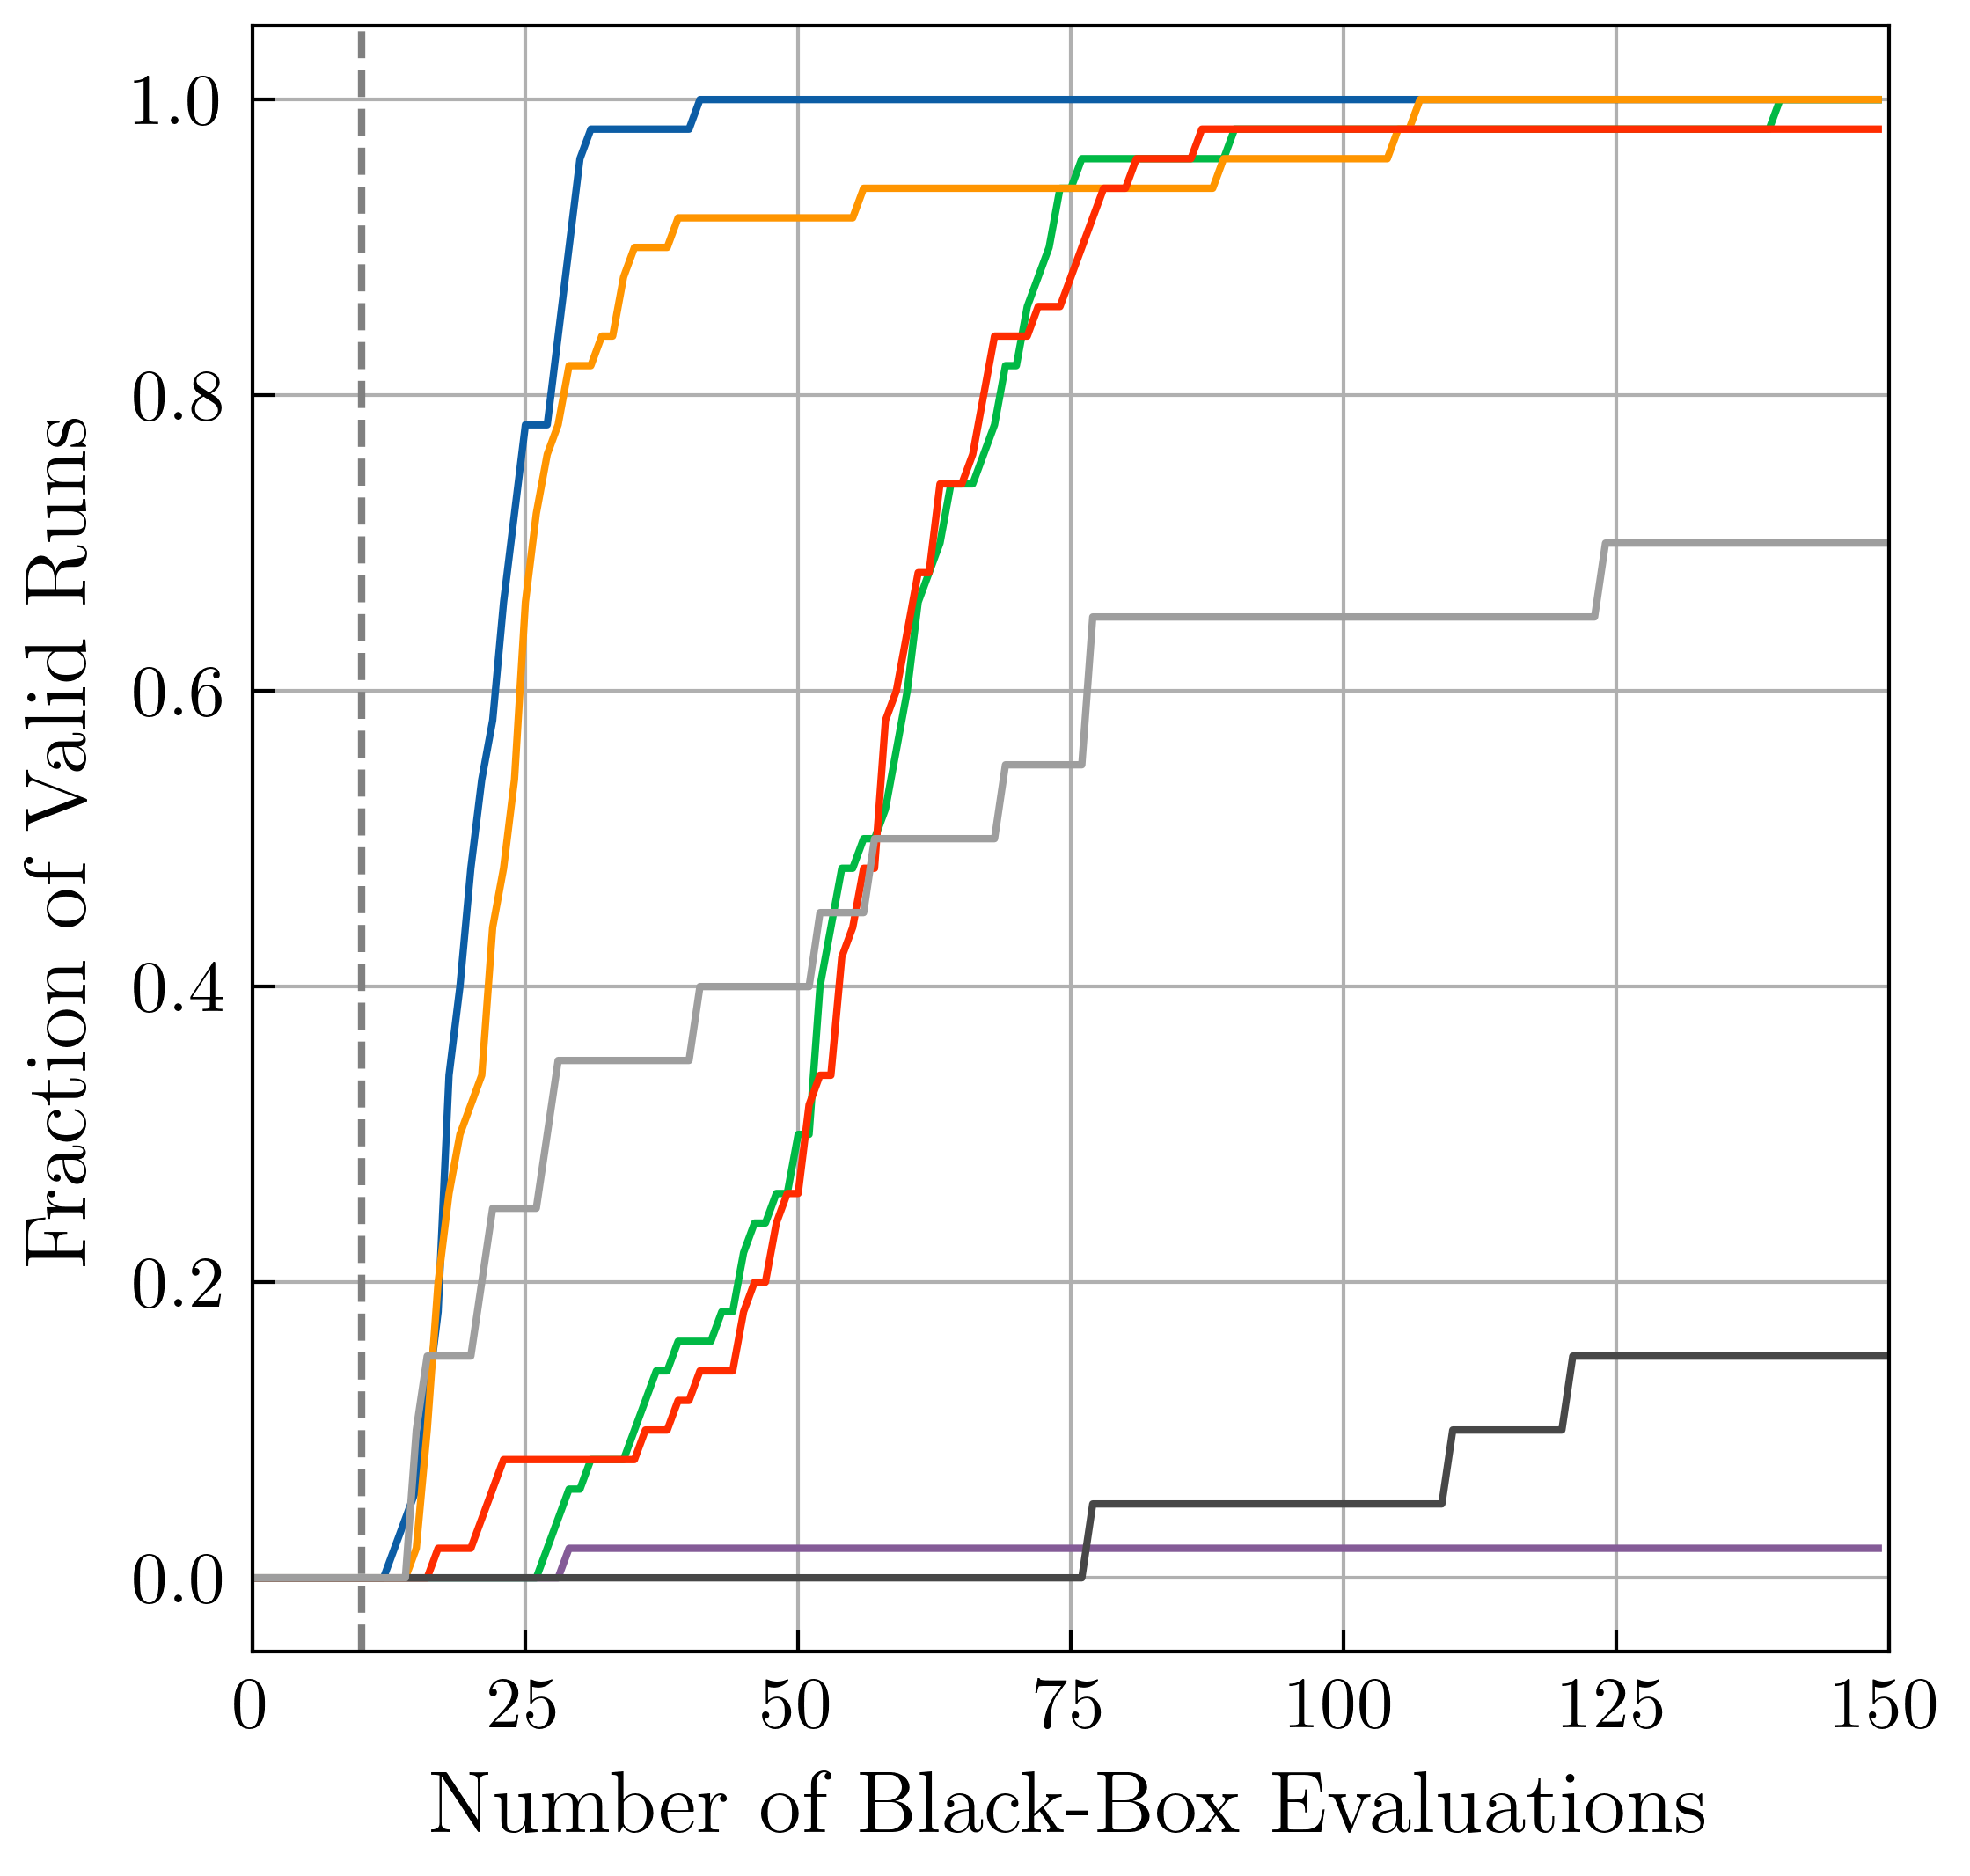

In [65]:
plt.figure(figsize=(4,4))
plt.plot(feasible_fraction_original_albo_no_ey_aggressive, label="EI-AL")
plt.plot(feasible_fraction_original_albo_no_ey_conservative, label="EI-AL Conservative")
# plt.plot(feasible_fraction_adam_aggressive, label="TS-AL + Aggressive")
# plt.plot(feasible_fraction_adam_conservative, label="TS-AL + Conservative")
# plt.plot(feasible_fraction_adam_no_prev_aggressive, label="TS-AL + Aggresive (No Prev)")
# plt.plot(feasible_fraction_adam_no_prev_conservative, label="TS-AL + Conservative (No Prev)")
plt.plot(feasible_fraction_adam_rbf_aggressive, label="TS-AL")
plt.plot(feasible_fraction_adam_rbf_conservative, label="TS-AL Conservative")
plt.plot(feasible_fraction_random, label="Random")
plt.plot(feasible_fraction_kkt, label="KKT-EGO")
plt.plot(feasible_fraction_kkt_feasible, label="KKT-EGO Feasible")
plt.axvline(x=10, color='grey', linestyle='--')
plt.xlabel('Number of Black-Box Evaluations')
plt.ylabel('Fraction of Valid Runs')
plt.xlim(0, 150)
# plt.legend()
plt.savefig("figs/gsbp_valid_runs.png")
plt.show()

In [67]:
def fraction_of_runs_found_optimal_point(all_runs: np.array,
                                         num_runs: int,
                                         optimal_val: float):
    assert(all_runs.shape[0] == num_runs)
    found_optimal_point = np.where(all_runs == optimal_val, 1, 0)
    optimal_fraction = np.sum(found_optimal_point, axis=0)/num_runs
    return optimal_fraction

In [68]:
optimal_fraction_adam_aggressive = fraction_of_runs_found_optimal_point(ts_al_adam_aggressive_gsbp_results, 50, -0.5273951)
optimal_fraction_adam_conservative = fraction_of_runs_found_optimal_point(ts_al_adam_conservative_gsbp_results, 50, -0.5273951)
optimal_fraction_random = fraction_of_runs_found_optimal_point(random_gsbp_results, 50, -0.5273951)
optimal_fraction_original_albo_no_ey_aggressive = fraction_of_runs_found_optimal_point(original_albo_aggressive_no_ey_gsbp_results, 50, -0.5273951)
optimal_fraction_original_albo_no_ey_conservative = fraction_of_runs_found_optimal_point(original_albo_conservative_no_ey_gsbp_results, 50, -0.5273951)
optimal_fraction_adam_no_prev_aggressive = fraction_of_runs_found_optimal_point(ts_al_adam_no_prev_aggressive_results, 50, -0.5273951)
optimal_fraction_adam_no_prev_conservative = fraction_of_runs_found_optimal_point(ts_al_adam_no_prev_conservative_results, 50, -0.5273951)
optimal_fraction_adam_no_prev_rbf_aggressive = fraction_of_runs_found_optimal_point(ts_al_adam_no_prev_rbf_aggressive_results, 50, -0.5273951)
optimal_fraction_adam_no_prev_rbf_conservative = fraction_of_runs_found_optimal_point(ts_al_adam_no_prev_rbf_conservative_results, 50, -0.5273951)
optimal_fraction_kkt = fraction_of_runs_found_optimal_point(final_kkt_gsbp_results, 20, -0.5273951)
optimal_fraction_kkt_feasible = fraction_of_runs_found_optimal_point(final_kkt_feasible_only_gsbp_results, 20, -0.5273951)

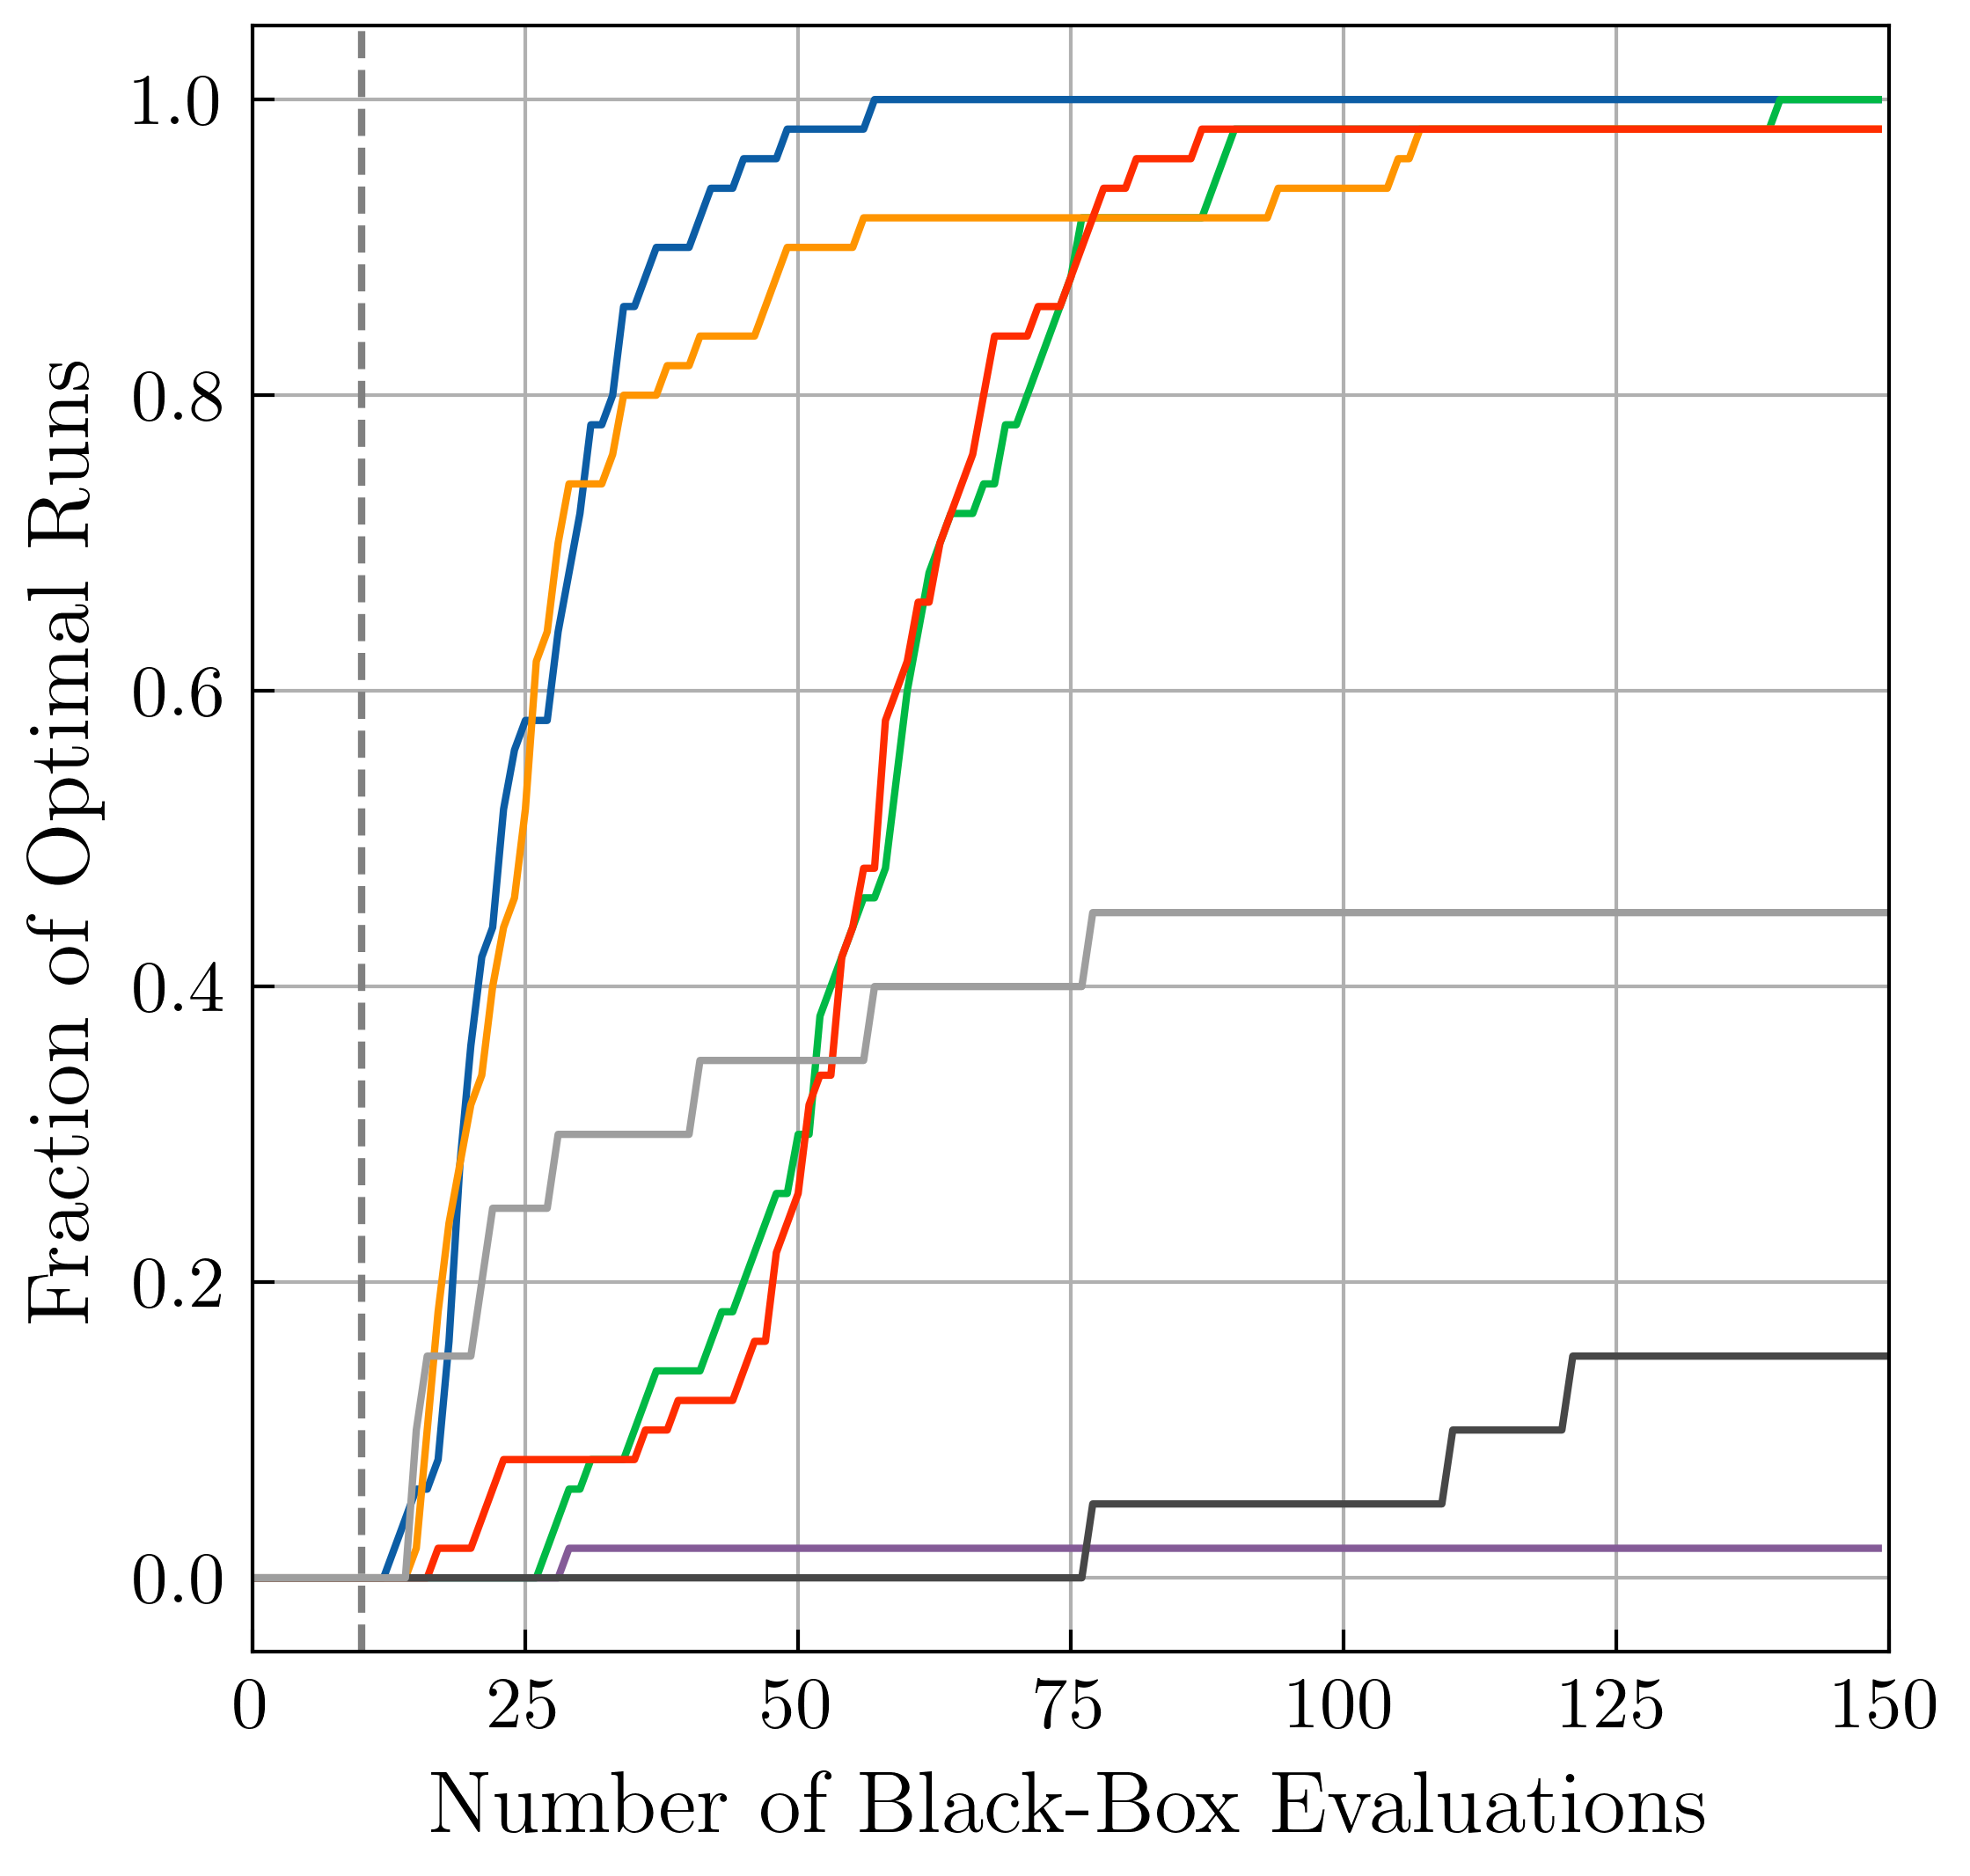

In [69]:
plt.figure(figsize=(4,4))
plt.plot(optimal_fraction_original_albo_no_ey_aggressive, label="EI-AL")
plt.plot(optimal_fraction_original_albo_no_ey_conservative, label="EI-AL Conservative")
plt.plot(optimal_fraction_adam_no_prev_rbf_aggressive, label="TS-AL")
plt.plot(optimal_fraction_adam_no_prev_rbf_conservative, label="TS-AL Conservative")
plt.plot(optimal_fraction_random, label="Random")
plt.plot(optimal_fraction_kkt, label="KKT-EGO")
plt.plot(optimal_fraction_kkt_feasible, label="KKT-EGO Feasible")
plt.axvline(x=10, color='grey', linestyle='--')
plt.xlabel('Number of Black-Box Evaluations')
plt.ylabel('Fraction of Optimal Runs')
plt.xlim(0, 150)
# plt.legend()
plt.savefig("figs/gsbp_optimal_runs.png")
plt.show()